In [15]:
import yfinance as yf
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from tqdm.notebook import trange, tqdm
from pypfopt import HRPOpt
from pypfopt import expected_returns

import warnings
warnings.filterwarnings('ignore')

In [16]:
# Define the tickers and date range 
tickers = ["CGL.TO",  # iShares Gold Bullion ETF (CAD-Hedged)
           "HBD.TO",  # BetaPro Gold Bullion -2x Daily Bear ETF
           "VFV.TO",  # Vanguard S&P 500 Index ETF
           "HIU.TO",  # BetaPro S&P 500 Daily Inverse ETF
           "XGB.TO",  # iShares Core Canadian Government Bond Index ETF
           "XEQT.TO", # iShares Core Equity ETF Portfolio
           "ENB.TO",  # Enbridge Inc.
           "RY.TO",   # Royal Bank of Canada
           "WMT",     # Walmart Inc.
           "AAPL",    # Apple Inc.
           "V",       # Visa Inc.
           "MSFT",    # Microsoft Corporation
           "BRK-B",   # Berkshire Hathaway Inc.
           "TSLA",    # Tesla Inc.
           "NVDA",    # NVIDIA Corporation
           "AMD",     # Advanced Micro Devices Inc.
           "BLK",     # BlackRock Inc.
           "JPM",     # JPMorgan Chase & Co.
           ]  

sector_mapper = {
    "CGL.TO": "Commodities",
    "HBD.TO": "Commodities",
    "VFV.TO": "Equity Index",
    "HIU.TO": "Equity Index",
    "XGB.TO": "Fixed Income",
    "XEQT.TO": "Multi-Asset",
    "ENB.TO": "Energy",
    "RY.TO": "Financials",
    "WMT": "Consumer Staples",
    "AAPL": "Technology",
    "V": "Financials",
    "MSFT": "Technology",
    "BRK-B": "Financials",
    "TSLA": "Risky",
    "NVDA": "Risky",
    "AMD": "Risky",
    "BLK": "Financials",
    "JPM": "Financials"
}

tickers_CAD = ["CGL.TO",  # iShares Gold Bullion ETF (CAD-Hedged)
               "HBD.TO",  # BetaPro Gold Bullion -2x Daily Bear ETF
               "VFV.TO",  # Vanguard S&P 500 Index ETF
               "HIU.TO",  # BetaPro S&P 500 Daily Inverse ETF
               "XGB.TO",  # iShares Core Canadian Government Bond Index ETF
               "XEQT.TO", # iShares Core Equity ETF Portfolio
               "ENB.TO",  # Enbridge Inc.
               "RY.TO",   # Royal Bank of Canada
               "WMT.NE",  # Walmart Inc.
               "APLY.NE", # Apple Inc.
               "VISA.NE", # Visa Inc.
               "MSFT.NE", # Microsoft Corporation
               "BRK.NE",  # Berkshire Hathaway Inc.
               "TSLA.NE", # Tesla Inc.
               "NVDA.NE", # NVIDIA Corporation
               "AMD.NE",  # Advanced Micro Devices Inc.
               "BLK.NE",  # BlackRock Inc.
               "JPM.NE",  # JPMorgan Chase & Co.
]  

sector_mapper_CAD = {
    "CGL.TO": "Commodities",
    "HBD.TO": "Commodities",
    "VFV.TO": "Equity Index",
    "HIU.TO": "Equity Index",
    "XGB.TO": "Fixed Income",
    "XEQT.TO": "Multi-Asset",
    "ENB.TO": "Energy",
    "RY.TO": "Financials",
    "WMT.NE": "Consumer Staples",
    "APLY.NE": "Technology",
    "VISA.NE": "Financials",
    "MSFT.NE": "Technology",
    "BRK.NE": "Financials",
    "TSLA.NE": "Risky",
    "NVDA.NE": "Risky",
    "AMD.NE": "Risky",
    "BLK.NE": "Financials",
    "JPM.NE": "Financials"
}

# "Equity Index": 0.25,
# "Commodities": 0.10,
# "Multi-Asset": 0.25,

sector_lower = {
    "Equity Index": 0.25,
    "Multi-Asset": 0.25,
}  

sector_upper = {
    "Risky": 0.40, 
}

start_date = "2016-01-05"
start_date_CAD = "2024-01-05"
# Use the current date as the end date
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
# Fetch data from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date)
data_CAD = yf.download(tickers_CAD, start=start_date_CAD, end=end_date)
# Extract the 'Close' prices
prices = data['Close']
prices_CAD = data_CAD['Close']

# Add all missing dates
all_dates = pd.date_range(start_date, end_date)
prices = prices.reindex(pd.date_range(start_date, end_date))
prices_CAD = prices_CAD.reindex(pd.date_range(start_date_CAD, end_date))

# Fill NaN value with previous date value
prices = prices.fillna(method='ffill')
prices_CAD = prices_CAD.fillna(method='ffill')

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed


In [17]:
prices

Ticker,AAPL,AMD,BLK,BRK-B,CGL.TO,ENB.TO,HBD.TO,HIU.TO,JPM,MSFT,NVDA,RY.TO,TSLA,V,VFV.TO,WMT,XEQT.TO,XGB.TO
2016-01-05,25.677500,2.750000,333.959991,131.250000,9.50,46.000000,44.820000,40.720001,63.730000,55.049999,0.822250,72.820000,14.895333,76.269997,50.040001,20.973333,NaN,22.090000
2016-01-06,25.174999,2.510000,330.160004,131.330002,9.62,44.580002,43.740002,41.099998,62.810001,54.049999,0.788250,71.570000,14.602667,75.269997,49.709999,21.183332,NaN,22.180000
2016-01-07,24.112499,2.280000,315.730011,129.479996,9.75,43.700001,42.880001,41.939999,60.270000,52.169998,0.757000,70.250000,14.376667,73.790001,48.630001,21.676666,NaN,22.190001
2016-01-08,24.240000,2.140000,307.779999,128.330002,9.75,44.889999,43.099998,42.480000,58.919998,52.330002,0.740750,70.070000,14.066667,72.879997,48.200001,21.180000,NaN,22.180000
2016-01-09,24.240000,2.140000,307.779999,128.330002,9.75,44.889999,43.099998,42.480000,58.919998,52.330002,0.740750,70.070000,14.066667,72.879997,48.200001,21.180000,NaN,22.180000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-03,219.860001,132.500000,846.020020,428.359985,19.41,52.610001,7.560000,11.990000,199.139999,408.489990,107.269997,148.960007,207.669998,266.579987,131.470001,68.459999,30.66,19.639999
2024-08-04,219.860001,132.500000,846.020020,428.359985,19.41,52.610001,7.560000,11.990000,199.139999,408.489990,107.269997,148.960007,207.669998,266.579987,131.470001,68.459999,30.66,19.639999
2024-08-05,209.270004,134.820007,830.760010,413.720001,19.41,52.610001,7.560000,11.990000,194.899994,395.149994,100.449997,148.960007,198.880005,256.440002,131.470001,67.589996,30.66,19.639999
2024-08-06,207.229996,130.179993,840.960022,422.140015,18.98,52.759998,7.890000,12.170000,200.339996,399.609985,104.250000,147.949997,200.639999,258.260010,128.100006,67.739998,29.99,19.440001


In [18]:
initial_investment_amount = 1500
investment_starting_date = "2023-01-01"

# Get a dataframe of portfolio value of only investing in S&P500 (XUS.TO)
sp500 = prices['VFV.TO']
sp500 = sp500[sp500.index >= investment_starting_date]
sp500 = sp500 / sp500.iloc[0] * initial_investment_amount

In [19]:
def get_optimal_allocation(date, prices, total_portfolio_value, if_hrp=False, if_min_volatility=False, verbose=False):
    """
    Calculate the optimal allocation based on the given parameters.
    
    :param date: Date to calculate the optimal allocation
    :param prices: DataFrame of historical prices
    :param total_portfolio_value: Current total portfolio value
    :param if_hrp: 
    :param if_min_volatility: 
    :return: Dictionary of allocations and leftover cash
    """
    # Ensure the index is in the correct format
    prices.index = pd.to_datetime(prices.index)

    # Filter the prices based on the date range
    prices = prices.loc[:date]

    if if_hrp:
        mu = expected_returns.returns_from_prices(prices)

        hrp = HRPOpt(mu)
        
        # Add sector constraints
        hrp.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

        hrp.optimize()

        cleaned_weights = hrp.clean_weights()

        # Get portfolio performance metrics
        expected_annual_return, annual_volatility, sharpe_ratio = hrp.portfolio_performance(verbose=verbose)
    else:
        # Calculate expected returns and sample covariance matrix
        # mu = ema_historical_return(prices, frequency=252)
        mu = expected_returns.mean_historical_return(prices)
        
        S = CovarianceShrinkage(prices).ledoit_wolf()

        # Optimize the portfolio
        ef = EfficientFrontier(mu, S)

        # Add L2 regularization to the optimization problem
        ef.add_objective(objective_functions.L2_reg, gamma=0.1)
        
        # Add sector constraints
        ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
        
        if if_min_volatility:
            weights = ef.min_volatility()  # Uncomment this line if you prefer min volatility
        else:
            weights = ef.max_sharpe()
        

        # Get the discrete allocation of each asset
        cleaned_weights = ef.clean_weights()

        # Get portfolio performance metrics
        expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance(verbose=verbose)

    # Get the latest prices
    latest_prices = get_latest_prices(prices)

    # Calculate the discrete allocation
    da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=total_portfolio_value)
    allocation, leftover = da.lp_portfolio()

    # Fill the tickers that are not in the allocation with 0
    for ticker in tickers:
        if ticker not in allocation:
            allocation[ticker] = 0

    return {
        'allocation': allocation,
        'leftover': leftover,
        'weights': cleaned_weights,
        'expected_annual_return': expected_annual_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio': sharpe_ratio,
    }


In [20]:
# Create a MVO dataframe with current portfolio value, all elements from the tickers, and left over cash columns
date_range = pd.date_range(investment_starting_date, end_date)
mvo = pd.DataFrame(index=date_range, columns=['Portfolio Value', 'Leftover Cash', 'isError'] + tickers)

# Initialize the portfolio
portfolio_value = initial_investment_amount
previous_allocation = pd.Series(0, index=tickers)
previous_leftover_cash = initial_investment_amount

In [21]:
# Iterate from the investment_starting_date to the end_date
for date in tqdm(date_range):
    # If the date is not a trading day, skip it
    if date not in prices.index:
        continue
    
    # Calculate the current portfolio value
    if date == pd.to_datetime(investment_starting_date):
        portfolio_value = initial_investment_amount
    else:
        price_at_date = prices.loc[date]
        portfolio_value = (price_at_date * previous_allocation).sum() + previous_leftover_cash
    
    # re-balance every Wednesday
    if date.weekday() != 2:
        try:
            # Get the optimal allocation
            allocation = get_optimal_allocation(date, prices, portfolio_value, if_hrp=False, if_min_volatility=False)
            mvo.loc[date, 'isError'] = False
        except Exception as e:
            # Use the same allocation as the previous day if an error occurs
            allocation = {
                'allocation': previous_allocation,
                'leftover': previous_leftover_cash
            }
            mvo.loc[date, 'isError'] = True
            print(e)
    else:
        # Use the same allocation as the previous day if it is not Wednesday
        mvo.loc[date, 'isError'] = False
        allocation = {
            'allocation': previous_allocation,
            'leftover': previous_leftover_cash
        }
    
    # Update the DataFrame
    mvo.loc[date, 'Portfolio Value'] = portfolio_value
    mvo.loc[date, tickers] = [allocation['allocation'].get(ticker, 0) for ticker in tickers]
    mvo.loc[date, 'Leftover Cash'] = allocation['leftover']
    
    # Update previous allocation and leftover cash for the next iteration
    # Convert the previous allocation to a Series to match the tickers
    previous_allocation = pd.Series(allocation['allocation'])
    previous_leftover_cash = allocation['leftover']
    

  0%|          | 0/585 [00:00<?, ?it/s]

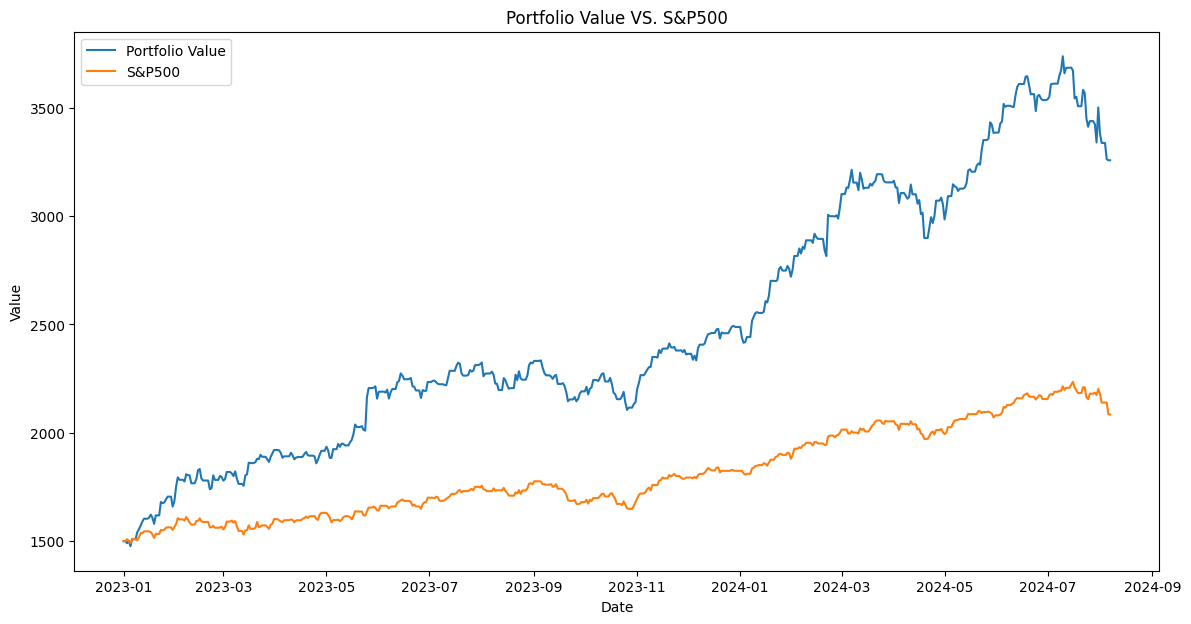

In [22]:
# Plot the portfolio value VS. S&P500
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

plt.plot(mvo['Portfolio Value'], label='Portfolio Value')
plt.plot(sp500, label='S&P500')
plt.title('Portfolio Value VS. S&P500')
plt.xlabel('Date')
plt.ylabel('Value')

plt.legend()
plt.show()


In [23]:
# Get the order dict for the last date by re-running the get_optimal_allocation function
current_allocation = get_optimal_allocation(end_date, prices, total_portfolio_value=1500, if_hrp=False, if_min_volatility=False, verbose=True)

Expected annual return: 22.0%
Annual volatility: 19.5%
Sharpe Ratio: 1.03


In [24]:
from collections import OrderedDict

# Your original orderDict
orderDict = OrderedDict([('AAPL', 0.0),
             ('AMD', 0.0),
             ('BLK', 0.0),
             ('BRK-B', 0.0),
             ('CGL.TO', 0.5),
             ('ENB.TO', 0.0),
             ('HBD.TO', 0.0),
             ('HIU.TO', 0.0),
             ('JPM', 0.0),
             ('MSFT', 0.0),
             ('NVDA', 0.0),
             ('RY.TO', 0.0),
             ('TSLA', 0.0),
             ('V', 0.0),
             ('VFV.TO', 0.25),
             ('WMT', 0.0),
             ('XEQT.TO', 0.25),
             ('XGB.TO', 0.0)])

# Create a mapping from tickers to tickers_CAD
ticker_mapping = dict(zip(tickers, tickers_CAD))

# Create a new OrderedDict with updated tickers
new_orderDict = OrderedDict()

for ticker, value in orderDict.items():
    if ticker in ticker_mapping:
        new_ticker = ticker_mapping[ticker]
        new_orderDict[new_ticker] = value
    else:
        new_orderDict[ticker] = value

# Print the new orderDict
new_orderDict

OrderedDict([('APLY.NE', 0.0),
             ('AMD.NE', 0.0),
             ('BLK.NE', 0.0),
             ('BRK.NE', 0.0),
             ('CGL.TO', 0.5),
             ('ENB.TO', 0.0),
             ('HBD.TO', 0.0),
             ('HIU.TO', 0.0),
             ('JPM.NE', 0.0),
             ('MSFT.NE', 0.0),
             ('NVDA.NE', 0.0),
             ('RY.TO', 0.0),
             ('TSLA.NE', 0.0),
             ('VISA.NE', 0.0),
             ('VFV.TO', 0.25),
             ('WMT.NE', 0.0),
             ('XEQT.TO', 0.25),
             ('XGB.TO', 0.0)])

In [25]:
# Get the latest prices
latest_prices = get_latest_prices(prices_CAD)

# Append the latest prices of VFV.TO
latest_prices['VFV.TO'] = prices['VFV.TO'].iloc[-1]


# Calculate the discrete allocation
allocation, leftover = DiscreteAllocation(new_orderDict, latest_prices, total_portfolio_value=1500).greedy_portfolio()

In [26]:
allocation, leftover

({'CGL.TO': 39, 'VFV.TO': 3, 'XEQT.TO': 12}, 15.60000228881836)

In [27]:
# Calculate the total value of the portfolio
total_value = sum([allocation[ticker] * latest_prices[ticker] for ticker in allocation]) + leftover

In [28]:
total_value

1500.0